In [ ]:
# connecting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dependencies
import os
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

#Data Extraction

In [ ]:
# import the dataset
PROJECT_ROOT = "/content/drive/MyDrive/COS429/cv_final_project"
DATASET_ROOT = os.path.join(PROJECT_ROOT, "archive")

In [ ]:
print(os.listdir(DATASET_ROOT))

['Val', 'Test', 'Train']


Separate into directories.

In [ ]:
def get_split_dirs(split):

    if split == 'train':
        split_root = os.path.join(DATASET_ROOT, 'Train')
    elif split == 'val':
        split_root = os.path.join(DATASET_ROOT, 'Val')
    else:
        split_root = os.path.join(DATASET_ROOT, 'Test')

    images_dir = os.path.join(split_root, split.capitalize(), "JPEGImages")
    annots_dir = os.path.join(split_root, split.capitalize(), "Annotations")
    list_file = os.path.join(split_root, split.capitalize(), f"{split}.txt")
    return images_dir, annots_dir, list_file

for s in ["train", "val", "test"]:
    images_dir, annots_dir, list_file = get_split_dirs(s)
    print(f"{s} images dir:    {images_dir}")
    print(f"{s} annots dir:    {annots_dir}")
    print(f"{s} list file:     {list_file}")
    print()

RESULTS_DIR = os.path.join(PROJECT_ROOT, "results_cnn")
os.makedirs(RESULTS_DIR, exist_ok=True)
print("Results will be saved to:", RESULTS_DIR)

train images dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Train/Train/JPEGImages
train annots dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Train/Train/Annotations
train list file:     /content/drive/MyDrive/COS429/cv_final_project/archive/Train/Train/train.txt

val images dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Val/Val/JPEGImages
val annots dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Val/Val/Annotations
val list file:     /content/drive/MyDrive/COS429/cv_final_project/archive/Val/Val/val.txt

test images dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Test/Test/JPEGImages
test annots dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Test/Test/Annotations
test list file:     /content/drive/MyDrive/COS429/cv_final_project/archive/Test/Test/test.txt

Results will be saved to: /content/drive/MyDrive/COS429/cv_final_project/results_cnn


In [ ]:
def parse_annotation(xml_path):

    import xml.etree.ElementTree as ET

    tree = ET.parse(xml_path)
    root = tree.getroot()

    objects = []
    for obj in root.findall('object'):
        name = obj.find('name').text.lower().strip()
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))
        objects.append({
            'label': name,
            'bbox': (xmin, ymin, xmax, ymax),
        })
    return objects


In [ ]:
person_labels    = {'person'}
nonperson_labels = {'person-like'}

def map_label_to_binary(name):

    name = name.lower()
    if name in person_labels:
        return 1
    if name in nonperson_labels:
        return 0
    print("there's a third label called ", name)
    return None


def resolve_image_path(images_dir, base_id):

    ext = ".jpg"

    candidate = os.path.join(images_dir, base_id + ext)
    if os.path.exists(candidate):
      return candidate
    return None

from tqdm.notebook import tqdm

def load_split_samples(split):

    images_dir, annots_dir, list_file = get_split_dirs(split)

    with open(list_file, 'r') as f:
        ids = [line.strip() for line in f if line.strip()]

    samples_grouped = []
    total_positives = 0
    total_negatives = 0

    for img_id in tqdm(ids, desc=f'Loading {split} samples'):
        base = os.path.splitext(img_id)[0]  # strip extension if present

        xml_path = os.path.join(annots_dir, base + ".xml")
        if not os.path.exists(xml_path):
            continue

        objs = parse_annotation(xml_path)

        img_path = resolve_image_path(images_dir, base)
        if img_path is None:
            print(f"[{split}] Warning: no image found for ID '{base}'")
            continue

        current_image_annotations = []
        # for each of the bounding boxes
        for o in objs:
            y = map_label_to_binary(o['label'])
            if y is None:
                continue  # skip labels we don't care about

            current_image_annotations.append({
                'bbox': o['bbox'],
                'label': o['label'],
                'y': y, # 1 if person, 0 if non-person label
            })
            if y == 1:
                total_positives += 1
            else:
                total_negatives += 1

        if current_image_annotations:
            samples_grouped.append({
                'img_path': img_path,
                'split': split,
                'annotations': current_image_annotations,
            })

    print(f"{split}: loaded {len(samples_grouped)} images with annotations")
    print(f"  total positives (person):     {total_positives}")
    print(f"  total negatives (non-person): {total_negatives}")
    return samples_grouped

In [ ]:
train_samples = load_split_samples("train")
val_samples   = load_split_samples("val")
test_samples  = load_split_samples("test")

labels_in_data = sorted({label for sample_group in (train_samples + val_samples + test_samples) for annotation in sample_group['annotations'] for label in [annotation['label']]})
print("Labels present across all splits:", labels_in_data)

Loading train samples:   0%|          | 0/944 [00:00<?, ?it/s]

train: loaded 944 images with annotations
  total positives (person):     1106
  total negatives (non-person): 960


Loading val samples:   0%|          | 0/160 [00:00<?, ?it/s]

val: loaded 160 images with annotations
  total positives (person):     203
  total negatives (non-person): 130


Loading test samples:   0%|          | 0/235 [00:00<?, ?it/s]

test: loaded 235 images with annotations
  total positives (person):     317
  total negatives (non-person): 278
Labels present across all splits: ['person', 'person-like']


In [ ]:
print(train_samples[0])

{'img_path': '/content/drive/MyDrive/COS429/cv_final_project/archive/Train/Train/JPEGImages/image (1).jpg', 'split': 'train', 'annotations': [{'bbox': (158, 44, 289, 167), 'label': 'person', 'y': 1}]}


Visualize an image.

{'img_path': '/content/drive/MyDrive/COS429/cv_final_project/archive/Train/Train/JPEGImages/image (111).jpg', 'split': 'train', 'annotations': [{'bbox': (3, 1, 351, 500), 'label': 'person', 'y': 1}]}


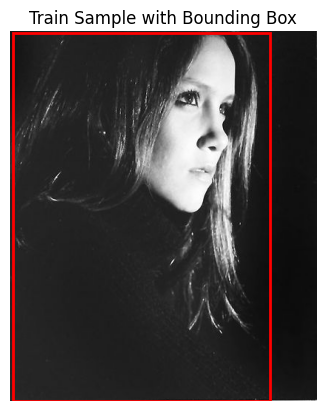

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

sample = train_samples[14]
print(sample)


image = Image.open(sample['img_path'])

fig, ax = plt.subplots(1)

ax.imshow(image)

for annotation in sample['annotations']:
    xmin, ymin, xmax, ymax = annotation['bbox']
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2,
                             edgecolor='r',
                             facecolor='none')
    ax.add_patch(rect)

ax.axis('off')

ax.set_title('Train Sample with Bounding Box')

plt.show()

# Training a Faster R-CNN Model

In [ ]:
# train a Faster R-CNN model
import matplotlib.pyplot as plt
import os
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

Prepare Custom Dataset


In [ ]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, samples, transforms=None):
        self.samples = samples
        self.transforms = transforms
        self.label_map = {0: 1, 1: 2}
        self.classes = ['__background__', 'non-person-like', 'person']

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_group = self.samples[idx]
        img_path = sample_group['img_path']

        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        for annotation in sample_group['annotations']:
            xmin, ymin, xmax, ymax = annotation['bbox']
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.label_map[annotation['y']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

transform = transforms.ToTensor()

train_dataset = ObjectDetectionDataset(train_samples, transforms=transform)
val_dataset = ObjectDetectionDataset(val_samples, transforms=transform)
test_dataset = ObjectDetectionDataset(test_samples, transforms=transform)

print(f"Number of samples in training dataset: {len(train_dataset)}")
print(f"Number of samples in validation dataset: {len(val_dataset)}")
print(f"Number of samples in test dataset: {len(test_dataset)}")

if len(train_dataset) > 0:
    first_img, first_target = train_dataset[0]
    print(f"\nShape of the first image tensor in train_dataset: {first_img.shape}")
    print(f"First target dictionary (boxes): {first_target['boxes']}")
    print(f"First target dictionary (labels): {first_target['labels']}")
    print(f"Mapped classes: {train_dataset.classes}")
else:
    print("\nTraining dataset is empty.")

Number of samples in training dataset: 944
Number of samples in validation dataset: 160
Number of samples in test dataset: 235

Shape of the first image tensor in train_dataset: torch.Size([3, 442, 500])
First target dictionary (boxes): tensor([[158.,  44., 289., 167.]])
First target dictionary (labels): tensor([2])
Mapped classes: ['__background__', 'non-person-like', 'person']


Define Data Transforms and Collator



In [ ]:
import torchvision.transforms as T


train_transform = T.Compose([
    T.Resize((800, 800)),
    T.RandomHorizontalFlip(0.5),
    T.ToTensor(),
])

val_test_transform = T.Compose([
    T.Resize((800, 800)),
    T.ToTensor(),
])


def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

print("Image transformations and collate_fn defined.")

Image transformations and collate_fn defined.


Create DataLoaders


In [ ]:
from torch.utils.data import DataLoader

batch_size = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Number of batches in training DataLoader: {len(train_dataloader)}")
print(f"Number of batches in validation DataLoader: {len(val_dataloader)}")
print(f"Number of batches in test DataLoader: {len(test_dataloader)}")

for images, targets in train_dataloader:
    print(f"\nFirst batch of training images (list of tensors, shape of first image): {images[0].shape}")
    print(f"First batch of training targets (list of dicts, content of first target): {targets[0]}")
    break

Number of batches in training DataLoader: 472
Number of batches in validation DataLoader: 80
Number of batches in test DataLoader: 118

First batch of training images (list of tensors, shape of first image): torch.Size([3, 375, 500])
First batch of training targets (list of dicts, content of first target): {'boxes': tensor([[  1.,  93., 255., 374.],
        [223.,   1., 500., 375.]]), 'labels': tensor([2, 2])}


Instantiate Faster R-CNN Model

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

num_classes_input_features = model.roi_heads.box_predictor.cls_score.in_features

num_classes = len(train_dataset.classes)

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(num_classes_input_features, num_classes)

print(f"Faster R-CNN model loaded with {num_classes_input_features} input features for classifier.")
print(f"Classifier head replaced to predict {num_classes} classes (including background).")
print("Modified model head:\n", model.roi_heads.box_predictor)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(f"Model moved to: {device}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 244MB/s]


Faster R-CNN model loaded with 1024 input features for classifier.
Classifier head replaced to predict 3 classes (including background).
Modified model head:
 FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=3, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=12, bias=True)
)
Model moved to: cuda


Initialize Learning Rate Scheduler

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

params = [p for p in model.parameters() if p.requires_grad]
print("Model parameters: ", model.parameters())

optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print("Optimizer and learning rate scheduler initialized.")

Model parameters:  <generator object Module.parameters at 0x7df66680fe60>
Optimizer and learning rate scheduler initialized.


Implement Training Loop

In [ ]:
from tqdm.notebook import tqdm

model.train()

num_epochs = 7

print("Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")


    train_iterator = tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}')

    total_loss_epoch = 0

    for i, (images, targets) in enumerate(train_iterator):
        images = list(image.to(device) for image in images)

        targets = [{
            'boxes': t['boxes'].to(device),
            'labels': t['labels'].to(device)
        } for t in targets]

        optimizer.zero_grad()

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        total_loss = losses.item()

        losses.backward()

        optimizer.step()

        train_iterator.set_postfix(loss=total_loss)
        total_loss_epoch += total_loss

    scheduler.step()

    avg_epoch_loss = total_loss_epoch / len(train_dataloader)
    print(f"Epoch {epoch+1} finished. Average Loss: {avg_epoch_loss:.4f}")

print("Training complete.")

Starting training...

Epoch 1/7


Training Epoch 1:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 1 finished. Average Loss: 0.2516

Epoch 2/7


Training Epoch 2:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 2 finished. Average Loss: 0.1756

Epoch 3/7


Training Epoch 3:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 3 finished. Average Loss: 0.1435

Epoch 4/7


Training Epoch 4:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 4 finished. Average Loss: 0.1016

Epoch 5/7


Training Epoch 5:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 5 finished. Average Loss: 0.0911

Epoch 6/7


Training Epoch 6:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 6 finished. Average Loss: 0.0861

Epoch 7/7


Training Epoch 7:   0%|          | 0/472 [00:00<?, ?it/s]

Epoch 7 finished. Average Loss: 0.0815
Training complete.


In [ ]:
model_save_path = os.path.join(RESULTS_DIR, 'faster_rcnn.pth')
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/COS429/cv_final_project/results_cnn/faster_rcnn.pth


Implement Evaluation Loop on Validation Set

In [ ]:
print("Starting validation...")

model.eval()

with torch.no_grad():
    val_iterator = tqdm(val_dataloader, desc='Validation')
    for i, (images, targets) in enumerate(val_iterator):
        images = list(image.to(device) for image in images)

        outputs = model(images)

        if i == 0:
            print("\nPredictions for the first batch of validation set:")
            for j, output in enumerate(outputs):
                print(f"  Image {j+1}:")
                print(f"    Boxes: {output['boxes'].cpu().numpy()}")
                print(f"    Labels: {output['labels'].cpu().numpy()}")
                print(f"    Scores: {output['scores'].cpu().numpy()}")
                if j == 1:
                    break

print("Validation complete.")

Starting validation...


Validation:   0%|          | 0/80 [00:00<?, ?it/s]


Predictions for the first batch of validation set:
  Image 1:
    Boxes: [[  2.4758668  61.76881   302.52493   426.79382  ]
 [119.43614   105.498985  318.23035   391.9474   ]
 [ 29.705296   56.802956  227.19095   340.52316  ]
 [  1.5351822 121.294235  166.03017   348.04333  ]]
    Labels: [2 2 2 2]
    Scores: [0.99531794 0.96031797 0.884758   0.8235261 ]
  Image 2:
    Boxes: [[ 90.21767 166.28848 337.21835 371.71533]
 [235.70198 159.01323 287.93466 248.10141]
 [219.6252  165.17082 346.08505 363.78244]
 [208.4077  163.97913 298.11365 301.18277]
 [255.91805 169.69102 345.78766 307.7212 ]]
    Labels: [2 2 2 2 2]
    Scores: [0.9805753  0.9725355  0.82359713 0.07462859 0.06186568]
Validation complete.


Run Inference on Test Data


In [ ]:
print("Starting inference on test data...")

model.eval()

all_predictions = []
all_ground_truth_boxes = []
all_ground_truth_labels = []

with torch.no_grad():
    test_iterator = tqdm(test_dataloader, desc='Test Inference')

    for i, (images, targets) in enumerate(test_iterator):

        images = list(image.to(device) for image in images)

        outputs = model(images)

        for j, output in enumerate(outputs):
            all_predictions.append({
                'boxes': output['boxes'].cpu().numpy(),
                'labels': output['labels'].cpu().numpy(),
                'scores': output['scores'].cpu().numpy()
            })

        for j, target in enumerate(targets):
            all_ground_truth_boxes.append(target['boxes'].cpu().numpy())
            all_ground_truth_labels.append(target['labels'].cpu().numpy())

print(f"Inference complete. Total predictions collected: {len(all_predictions)}")
print(f"Total ground truth annotations collected: {len(all_ground_truth_boxes)}")

Starting inference on test data...


Test Inference:   0%|          | 0/118 [00:00<?, ?it/s]

Inference complete. Total predictions collected: 235
Total ground truth annotations collected: 235


Collect Ground Truth for Test Data


In [ ]:
print("\nFirst 5 entries of all_ground_truth_boxes:")
for i, boxes in enumerate(all_ground_truth_boxes[:5]):
    print(f"  Image {i+1} Boxes: {boxes}")

print("\nFirst 5 entries of all_ground_truth_labels:")
for i, labels in enumerate(all_ground_truth_labels[:5]):
    print(f"  Image {i+1} Labels: {labels}")


First 5 entries of all_ground_truth_boxes:
  Image 1 Boxes: [[  8.  12. 352. 498.]]
  Image 2 Boxes: [[ 22.  70. 254. 327.]
 [338.  12. 500. 199.]]
  Image 3 Boxes: [[199.  81. 359. 296.]]
  Image 4 Boxes: [[  4.  69. 432. 197.]]
  Image 5 Boxes: [[ 51.   2. 325. 375.]]

First 5 entries of all_ground_truth_labels:
  Image 1 Labels: [2]
  Image 2 Labels: [2 2]
  Image 3 Labels: [2]
  Image 4 Labels: [2]
  Image 5 Labels: [2]


# Evaluation

Visualize Sample Predictions vs. Ground Truth

Visualizing sample predictions vs. ground truth...


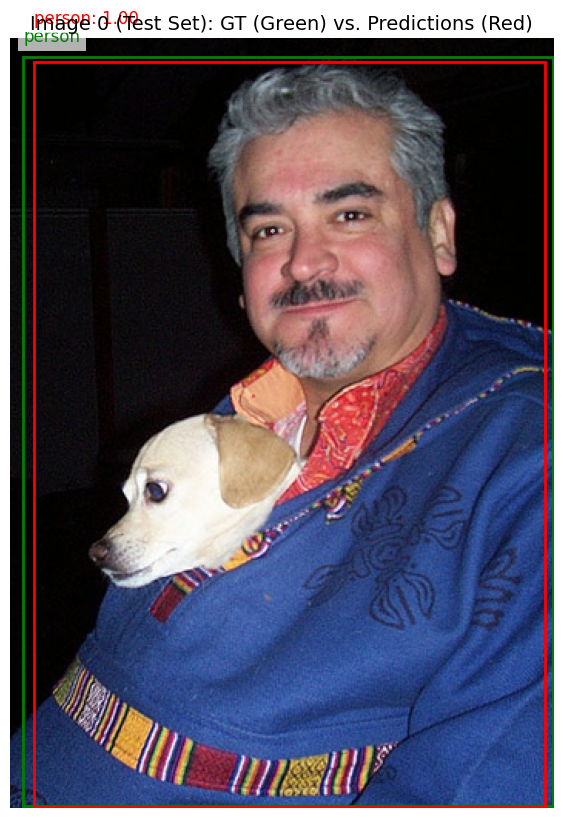

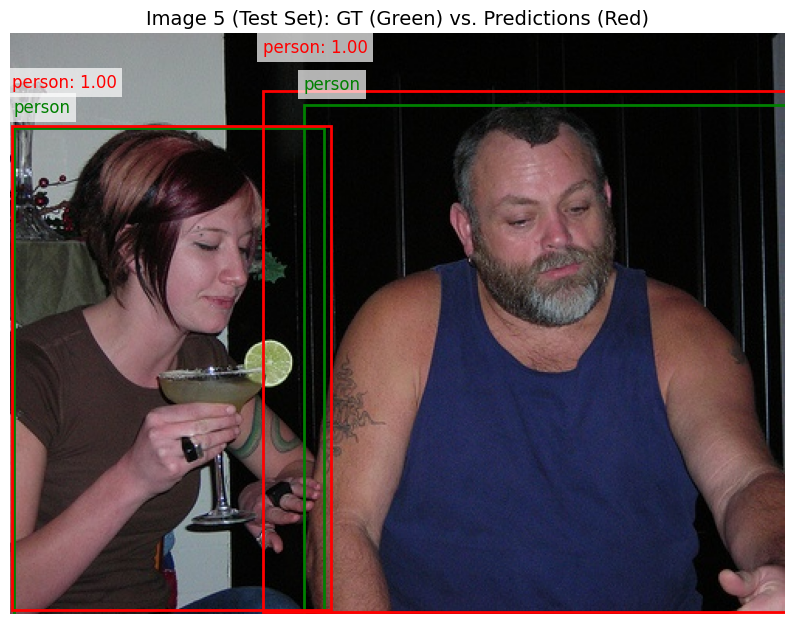

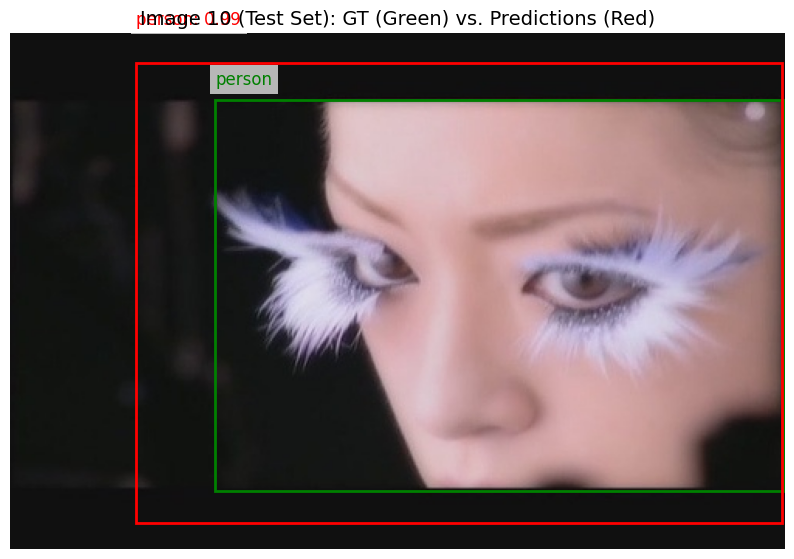

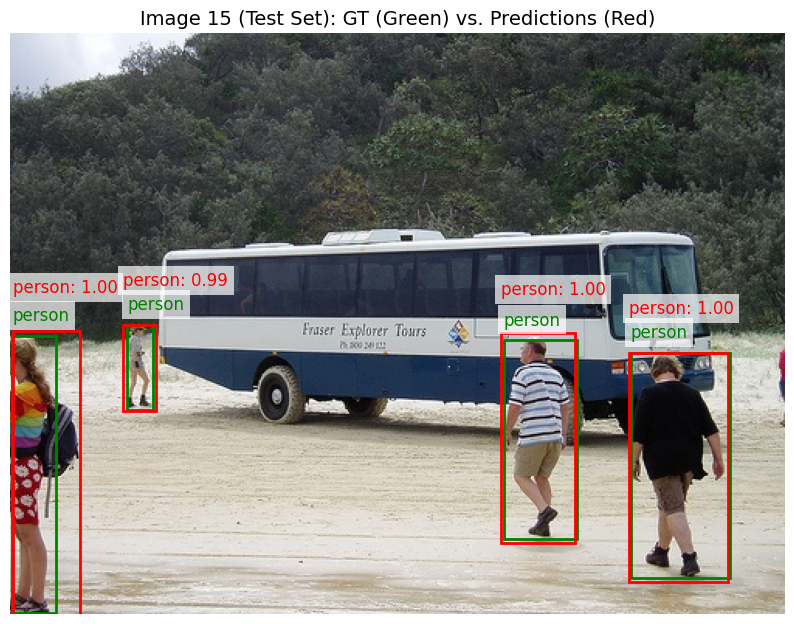

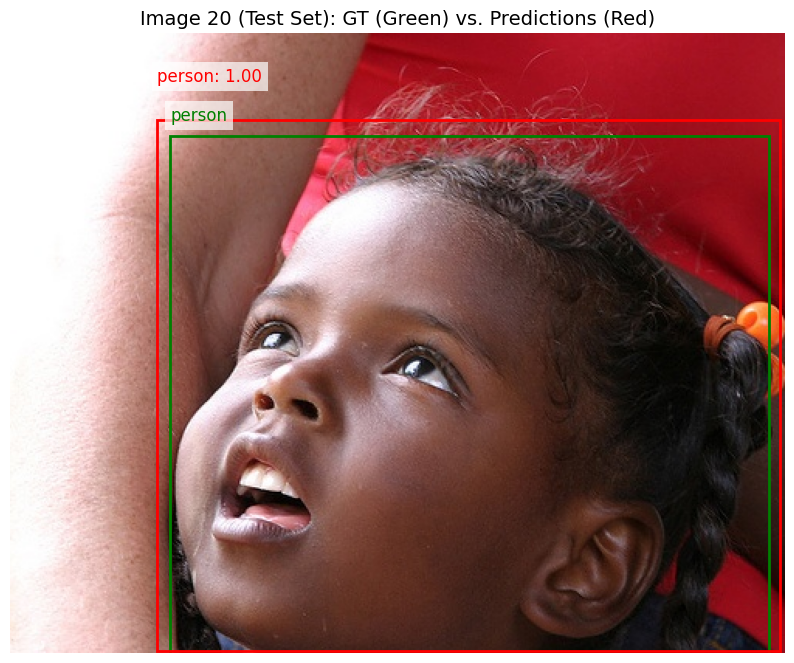

Visualization complete.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

selected_image_indices = [0, 5, 10, 15, 20]

idx_to_label = {1: 'non-person-like', 2: 'person'}

score_threshold = 0.5

print("Visualizing sample predictions vs. ground truth...")

for image_index in selected_image_indices:

    img_path = test_samples[image_index]['img_path']
    image = Image.open(img_path).convert('RGB')


    gt_boxes = all_ground_truth_boxes[image_index]
    gt_labels = all_ground_truth_labels[image_index]


    pred_data = all_predictions[image_index]
    pred_boxes = pred_data['boxes']
    pred_labels = pred_data['labels']
    pred_scores = pred_data['scores']

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)


    for i, gt_box in enumerate(gt_boxes):
        xmin, ymin, xmax, ymax = gt_box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        gt_label_text = idx_to_label[gt_labels[i]]
        ax.text(xmin, ymin - 10, gt_label_text, color='g', fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    for i, pred_box in enumerate(pred_boxes):
        if pred_scores[i] >= score_threshold:
            xmin, ymin, xmax, ymax = pred_box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            pred_label_text = idx_to_label[pred_labels[i]]
            ax.text(xmin, ymin - 25, f"{pred_label_text}: {pred_scores[i]:.2f}", color='r', fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))


    ax.set_title(f"Image {image_index} (Test Set): GT (Green) vs. Predictions (Red)", fontsize=14)
    ax.axis('off')
    plt.show()

print("Visualization complete.")

Plotting predictions

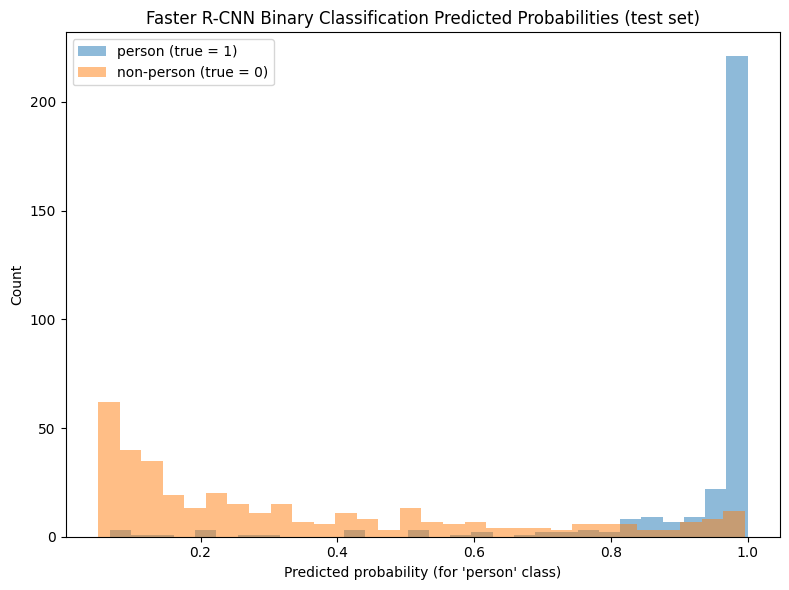

Histogram of predicted probabilities for Faster R-CNN binary classification model generated.


In [ ]:
def calculate_iou_viz(box1, box2):
    xmin_inter = max(box1[0], box2[0])
    ymin_inter = max(box1[1], box2[1])
    xmax_inter = min(box1[2], box2[2])
    ymax_inter = min(box1[3], box2[3])
    inter_area = max(0, xmax_inter - xmin_inter) * max(0, ymax_inter - ymin_inter)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0


y_scores_person = []
y_true_label = []

if 'all_predictions' in globals() and 'all_ground_truth_boxes' in globals():
    PERSON_LABEL_IDX = 2

    for i in range(len(all_predictions)):
        pred_boxes = all_predictions[i]['boxes']
        pred_labels = all_predictions[i]['labels']
        pred_scores = all_predictions[i]['scores']

        gt_boxes = all_ground_truth_boxes[i]
        gt_labels = all_ground_truth_labels[i]

        gt_person_mask = (gt_labels == PERSON_LABEL_IDX)
        gt_person_boxes = gt_boxes[gt_person_mask]

        person_pred_indices = [idx for idx, label in enumerate(pred_labels) if label == PERSON_LABEL_IDX]
        person_pred_indices.sort(key=lambda idx: pred_scores[idx], reverse=True)

        matched_gt_indices = set()

        for p_idx in person_pred_indices:
            score = pred_scores[p_idx]
            p_box = pred_boxes[p_idx]
            y_scores_person.append(score)

            best_iou = 0
            best_gt_idx = -1

            for g_idx, g_box in enumerate(gt_person_boxes):
                if g_idx in matched_gt_indices:
                    continue
                iou = calculate_iou_viz(p_box, g_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = g_idx

            if best_iou >= 0.5:
                y_true_label.append(1)
                matched_gt_indices.add(best_gt_idx)
            else:
                y_true_label.append(0)

    y_pred_proba_test_binary = np.array(y_scores_person)
    y_true_test_binary = np.array(y_true_label)

    plt.figure(figsize=(8, 6))
    if len(y_pred_proba_test_binary) > 0:
        plt.hist(y_pred_proba_test_binary[y_true_test_binary == 1], bins=30, alpha=0.5, label='person (true = 1)')
        plt.hist(y_pred_proba_test_binary[y_true_test_binary == 0], bins=30, alpha=0.5, label='non-person (true = 0)')
        plt.xlabel("Predicted probability (for 'person' class)")
        plt.ylabel("Count")
        plt.legend()
        plt.title("Faster R-CNN Binary Classification Predicted Probabilities (test set)")
        plt.tight_layout()

        if 'RESULTS_DIR' in globals():
            plt.savefig(os.path.join(RESULTS_DIR, "faster_rcnn_binary_classification_scores_test.png"), dpi=200)
        else:
            print("Warning: RESULTS_DIR not defined. Plot will not be saved to file.")

    plt.show()
    print("Histogram of predicted probabilities for Faster R-CNN binary classification model generated.")
else:
    print("Predictions or ground truth data not found. Please run inference first.")

In [ ]:
print(f"Total number of datapoints in the histogram: {len(y_pred_proba_test_binary)}")

Total number of datapoints in the histogram: 669


In [ ]:
eval_data = []

for i in range(len(test_samples)):
    image_path = test_samples[i]['img_path']
    predictions = all_predictions[i]
    ground_truths = {
        'boxes': all_ground_truth_boxes[i],
        'labels': all_ground_truth_labels[i]
    }

    eval_data.append({
        'img_path': image_path,
        'predictions': predictions,
        'ground_truths': ground_truths
    })

print(f"Consolidated {len(eval_data)} entries into eval_data.")
if len(eval_data) > 0:
    print("First entry in eval_data:")
    print(eval_data[0])


Consolidated 235 entries into eval_data.
First entry in eval_data:
{'img_path': '/content/drive/MyDrive/COS429/cv_final_project/archive/Test/Test/JPEGImages/image (1).jpg', 'predictions': {'boxes': array([[ 15.228605,  15.177418, 347.06256 , 498.7266  ],
       [104.729744,   9.427763, 353.      , 312.73395 ],
       [  4.43993 , 147.81892 , 333.79282 , 496.02362 ]], dtype=float32), 'labels': array([2, 2, 1]), 'scores': array([0.9983707 , 0.31602412, 0.06989422], dtype=float32)}, 'ground_truths': {'boxes': array([[  8.,  12., 352., 498.]], dtype=float32), 'labels': array([2])}}


In [ ]:
def get_pr_data_for_iou_threshold(eval_data, iou_threshold, target_label=2):

    y_scores = []
    y_true_binary = []

    for data in eval_data:
        predictions = data['predictions']
        ground_truths = data['ground_truths']

        pred_boxes = predictions['boxes']
        pred_labels = predictions['labels']
        pred_scores = predictions['scores']

        gt_boxes = ground_truths['boxes']
        gt_labels = ground_truths['labels']

        target_gt_mask = (gt_labels == target_label)
        target_gt_boxes = gt_boxes[target_gt_mask]
        target_gt_labels = gt_labels[target_gt_mask]

        matched_gt = [False] * len(target_gt_boxes)

        sorted_pred_indices = np.argsort(pred_scores)[::-1]

        for i in sorted_pred_indices:
            pred_box = pred_boxes[i]
            pred_label = pred_labels[i]
            pred_score = pred_scores[i]

            if pred_label != target_label:
                continue

            y_scores.append(pred_score)

            best_iou = 0.0
            best_gt_idx = -1

            for j, gt_box in enumerate(target_gt_boxes):
                if not matched_gt[j]:
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = j

            if best_iou >= iou_threshold and best_gt_idx != -1:
                y_true_binary.append(1)
                matched_gt[best_gt_idx] = True
            else:
                y_true_binary.append(0)

    return np.array(y_scores), np.array(y_true_binary)

In [ ]:
def get_tp_fp_fn_at_threshold(eval_data, iou_threshold, score_threshold, target_label=2, distractor_label=1):

    total_tp = 0
    total_fp = 0
    total_fn = 0
    fp_distractor_count = 0
    fp_other_count = 0

    for data in eval_data:
        predictions = data['predictions']
        ground_truths = data['ground_truths']

        pred_boxes = predictions['boxes']
        pred_labels = predictions['labels']
        pred_scores = predictions['scores']

        gt_boxes = ground_truths['boxes']
        gt_labels = ground_truths['labels']

        high_score_preds_mask = (pred_scores >= score_threshold)
        filtered_pred_boxes = pred_boxes[high_score_preds_mask]
        filtered_pred_labels = pred_labels[high_score_preds_mask]

        target_gt_mask = (gt_labels == target_label)
        target_gt_boxes = gt_boxes[target_gt_mask]

        matched_target_gt = [False] * len(target_gt_boxes)

        current_image_tp = 0
        current_image_fp = 0

        # evaluate predictions
        for i, pred_box in enumerate(filtered_pred_boxes):
            pred_label = filtered_pred_labels[i]

            if pred_label == target_label: # only process predictions for the target class
                best_iou_with_target_gt = 0.0
                best_target_gt_idx = -1

                for j, target_gt_box in enumerate(target_gt_boxes):
                    if not matched_target_gt[j]:
                        iou = calculate_iou(pred_box, target_gt_box)
                        if iou > best_iou_with_target_gt:
                            best_iou_with_target_gt = iou
                            best_target_gt_idx = j

                if best_iou_with_target_gt >= iou_threshold and best_target_gt_idx != -1:
                    current_image_tp += 1
                    matched_target_gt[best_target_gt_idx] = True
                else:
                    current_image_fp += 1
                    is_distractor_fp = False
                    distractor_gt_mask = (gt_labels == distractor_label)
                    distractor_gt_boxes = gt_boxes[distractor_gt_mask]
                    for distractor_gt_box in distractor_gt_boxes:
                        if calculate_iou(pred_box, distractor_gt_box) >= iou_threshold: # Assuming same IoU for distractor overlap
                            is_distractor_fp = True
                            break

                    if is_distractor_fp:
                        fp_distractor_count += 1
                    else:
                        fp_other_count += 1

        current_image_fn = len(target_gt_boxes) - current_image_tp

        total_tp += current_image_tp
        total_fp += current_image_fp
        total_fn += current_image_fn

    return total_tp, total_fp, total_fn, fp_distractor_count, fp_other_count

print("Core evaluation functions (get_pr_data_for_iou_threshold, get_tp_fp_fn_at_threshold) defined.")

Core evaluation functions (get_pr_data_for_iou_threshold, get_tp_fp_fn_at_threshold) defined.


In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

iou_thresholds = np.arange(0.5, 1.0, 0.05)
ap_values = []

print("Calculating Average Precision for multiple IoU thresholds...")
for iou_thresh in iou_thresholds:
    y_scores, y_true_binary = get_pr_data_for_iou_threshold(eval_data, iou_thresh, target_label=2)

    if np.sum(y_true_binary == 1) == 0:
        ap_values.append(0.0)
    else:
        precision, recall, _ = precision_recall_curve(y_true_binary, y_scores)
        ap = auc(recall, precision)
        ap_values.append(ap)

mean_ap = np.mean(ap_values)

print(f"Mean Average Precision (mAP@[{iou_thresholds[0]:.2f}-{iou_thresholds[-1]:.2f}]): {mean_ap:.4f}")

Calculating Average Precision for multiple IoU thresholds...
Mean Average Precision (mAP@[0.50-0.95]): 0.7010


In [ ]:
import numpy as np

score_thresholds_for_f1_optimization = np.linspace(0.00, 1.00, 101)

max_f1_person = -1.0
optimal_score_threshold_person = -1.0

iou_threshold_for_f1_optimization = 0.50
target_label_person = 2
distractor_label_non_person = 1

print(f"Finding optimal score threshold for 'person' class at IoU={iou_threshold_for_f1_optimization:.2f}...")

for score_thresh in score_thresholds_for_f1_optimization:
    total_tp_person, total_fp, total_fn_person, fp_distractor, fp_other = get_tp_fp_fn_at_threshold(
        eval_data,
        iou_threshold_for_f1_optimization,
        score_thresh,
        target_label=target_label_person,
        distractor_label=distractor_label_non_person
    )

    precision_person = total_tp_person / (total_tp_person + total_fp) if (total_tp_person + total_fp) > 0 else 0
    recall_person = total_tp_person / (total_tp_person + total_fn_person) if (total_tp_person + total_fn_person) > 0 else 0

    f1_score_person = (2 * precision_person * recall_person) / (precision_person + recall_person) if (precision_person + recall_person) > 0 else 0

    if f1_score_person > max_f1_person:
        max_f1_person = f1_score_person
        optimal_score_threshold_person = score_thresh

print(f"Optimal Score Threshold for F1-score (Person at IoU={iou_threshold_for_f1_optimization:.2f}): {optimal_score_threshold_person:.2f}")
print(f"Maximum F1-score (Person at IoU={iou_threshold_for_f1_optimization:.2f}): {max_f1_person:.4f}")

Finding optimal score threshold for 'person' class at IoU=0.50...
Optimal Score Threshold for F1-score (Person at IoU=0.50): 0.81
Maximum F1-score (Person at IoU=0.50): 0.8734


Generate Qualitative Grid Plot



In [ ]:
PERSON_LABEL_IDX = 2
NON_PERSON_LIKE_LABEL_IDX = 1
idx_to_label = {NON_PERSON_LIKE_LABEL_IDX: 'Person-like', PERSON_LABEL_IDX: 'Person'}

results_summary['optimal_iou_threshold_f1'] = iou_threshold_for_f1_optimization
results_summary['optimal_score_threshold_person_f1_iou_0_5'] = optimal_score_threshold_person

num_images_to_plot = 8
num_available_images = len(eval_data)
selected_indices = np.random.choice(num_available_images, min(num_images_to_plot, num_available_images), replace=False)

iou_threshold_for_eval = results_summary['optimal_iou_threshold_f1']
score_threshold_for_eval = results_summary['optimal_score_threshold_person_f1_iou_0_5']

print(f"Generating qualitative plot with IoU Threshold: {iou_threshold_for_eval:.2f}, Score Threshold: {score_threshold_for_eval:.2f}")

n_cols = 4
n_rows = int(np.ceil(len(selected_indices) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

for plot_idx, image_index in enumerate(selected_indices):
    data = eval_data[image_index]
    img_path = data['img_path']
    predictions = data['predictions']
    ground_truths = data['ground_truths']

    image = Image.open(img_path).convert('RGB')
    ax = axes[plot_idx]
    ax.imshow(image)


    gt_boxes = ground_truths['boxes']
    gt_labels = ground_truths['labels']
    gt_person_mask = (gt_labels == PERSON_LABEL_IDX)
    gt_person_boxes = gt_boxes[gt_person_mask]
    gt_non_person_mask = (gt_labels == NON_PERSON_LIKE_LABEL_IDX)
    gt_non_person_boxes = gt_boxes[gt_non_person_mask]
    matched_gt_person = [False] * len(gt_person_boxes)

    for gt_box, gt_label in zip(gt_boxes, gt_labels):
        xmin, ymin, xmax, ymax = gt_box
        color = 'purple' if gt_label == PERSON_LABEL_IDX else 'brown'
        label_text = idx_to_label[gt_label]
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, f'GT {label_text}', color=color, fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))


    pred_boxes = predictions['boxes']
    pred_labels = predictions['labels']
    pred_scores = predictions['scores']
    high_score_pred_indices = np.where(pred_scores >= score_threshold_for_eval)[0]

    for p_idx in high_score_pred_indices:
        pred_box = pred_boxes[p_idx]
        pred_label = pred_labels[p_idx]
        pred_score = pred_scores[p_idx]

        if pred_label == PERSON_LABEL_IDX:
            is_tp = False
            best_iou_with_person_gt = 0.0
            best_person_gt_idx = -1

            for gt_idx, person_gt_box in enumerate(gt_person_boxes):
                if not matched_gt_person[gt_idx]:
                    iou = calculate_iou(pred_box, person_gt_box)
                    if iou > best_iou_with_person_gt:
                        best_iou_with_person_gt = iou
                        best_person_gt_idx = gt_idx

            if best_iou_with_person_gt >= iou_threshold_for_eval and best_person_gt_idx != -1:
                is_tp = True
                matched_gt_person[best_person_gt_idx] = True
                color = 'mediumseagreen'
                status_text = 'TP'
            else:
                color = 'red'
                status_text = 'FP'

                is_distractor_fp = False
                for non_person_gt_box in gt_non_person_boxes:
                    if calculate_iou(pred_box, non_person_gt_box) >= iou_threshold_for_eval:
                        is_distractor_fp = True
                        break
                if is_distractor_fp:
                    status_text += ' (Distractor)'

            xmin, ymin, xmax, ymax = pred_box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     linewidth=2, edgecolor=color, facecolor='none', linestyle='-')
            ax.add_patch(rect)
            ax.text(xmin, ymin - 20, f'{status_text}: {idx_to_label[pred_label]}: {pred_score:.2f}',
                    color=color, fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))


    for gt_idx, person_gt_box in enumerate(gt_person_boxes):
        if not matched_gt_person[gt_idx]:
            xmin, ymin, xmax, ymax = person_gt_box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     linewidth=2, edgecolor='orange', facecolor='none', linestyle='--')
            ax.add_patch(rect)
            ax.text(xmin, ymax + 5, f'FN: {idx_to_label[PERSON_LABEL_IDX]}', color='orange', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    ax.set_title(f'Image {image_index}: GT vs. Preds (Score>{score_threshold_for_eval:.2f})', fontsize=10)
    ax.axis('off')

for i in range(plot_idx + 1, n_rows * n_cols):
    fig.delaxes(axes[i])

plt.tight_layout()

qual_plot_path = os.path.join(RESULTS_DIR, f'qual_{MODEL_NAME}.png')
plt.savefig(qual_plot_path, dpi=300)
print(f"Qualitative grid plot saved to: {qual_plot_path}")
plt.show()
print("Qualitative grid plot generated.")

Generating qualitative plot with IoU Threshold: 0.50, Score Threshold: 0.81
Qualitative grid plot saved to: /content/drive/MyDrive/COS429/cv_final_project/results_cnn/qual_faster_rcnn_resnet50_fpn.png


Qualitative grid plot generated.


Precision-Recall Curve for Person class

In [ ]:


print(f"Generating PR curves for 'person' class at IoU={iou_threshold_pr:.2f} (Test vs. Validation)...\n")

y_scores_test_person, y_true_binary_test_person = get_pr_data_for_iou_threshold(eval_data, iou_threshold_pr, target_label=PERSON_LABEL_IDX)

if np.sum(y_true_binary_test_person == 1) == 0:
    print(f"Warning: No positive samples found for 'person' class in TEST set at IoU={iou_threshold_pr:.2f}. AP set to 0.")
    ap_test_person = 0.0
else:
    precision_test_person, recall_test_person, _ = precision_recall_curve(y_true_binary_test_person, y_scores_test_person)
    ap_test_person = auc(recall_test_person, precision_test_person)

y_scores_val_person, y_true_binary_val_person = get_pr_data_for_iou_threshold(val_eval_data, iou_threshold_pr, target_label=PERSON_LABEL_IDX)

if np.sum(y_true_binary_val_person == 1) == 0:
    print(f"Warning: No positive samples found for 'person' class in VALIDATION set at IoU={iou_threshold_pr:.2f}. AP set to 0.")
    ap_val_person = 0.0
else:
    precision_val_person, recall_val_person, _ = precision_recall_curve(y_true_binary_val_person, y_scores_val_person)
    ap_val_person = auc(recall_val_person, precision_val_person)

plt.figure(figsize=(10, 8))
plt.plot(recall_test_person, precision_test_person, label=f'Test Set - Person (AP={ap_test_person:.2f})')
plt.plot(recall_val_person, precision_val_person, label=f'Validation Set - Person (AP={ap_val_person:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curves for "Person" class (IoU={iou_threshold_pr:.2f}) - Test vs. Validation')
plt.legend()
plt.grid(True)

pr_curve_person_test_vs_val_path = os.path.join(RESULTS_DIR, 'pr_curve_person_test_vs_val.png')
plt.savefig(pr_curve_person_test_vs_val_path, dpi=200)
print(f"PR curve plot saved to: {pr_curve_person_test_vs_val_path}")
plt.show()

results_summary['ap_person_test_iou_0_5'] = float(ap_test_person)
results_summary['ap_person_val_iou_0_5'] = float(ap_val_person)

print("AP values for 'person' class (Test and Validation) added to results_summary.")


Generating PR curves for 'person' class at IoU=0.50 (Test vs. Validation)...

PR curve plot saved to: /content/drive/MyDrive/COS429/cv_final_project/results_cnn/pr_curve_person_test_vs_val.png


AP values for 'person' class (Test and Validation) added to results_summary.


In [ ]:
print("Recalculating final confusion counts and metrics for 'person' class...")

iou_threshold_final_metrics = 0.50 k
optimal_score_threshold_person = results_summary['optimal_score_threshold_person_f1_iou_0_5']

total_tp_person, total_fp, total_fn_person, fp_distractor_count, fp_other_count = get_tp_fp_fn_at_threshold(
    eval_data,
    iou_threshold_final_metrics,
    optimal_score_threshold_person,
    target_label=PERSON_LABEL_IDX,
    distractor_label=NON_PERSON_LIKE_LABEL_IDX
)

precision_person_final = total_tp_person / (total_tp_person + total_fp) if (total_tp_person + total_fp) > 0 else 0.0
recall_person_final = total_tp_person / (total_tp_person + total_fn_person) if (total_tp_person + total_fn_person) > 0 else 0.0
f1_score_person_final = (2 * precision_person_final * recall_person_final) / (precision_person_final + recall_person_final) if (precision_person_final + recall_person_final) > 0 else 0.0


total_non_person_like_gt_objects = 0
for sample_group in test_samples:
    for annotation in sample_group['annotations']:
        if annotation['y'] == 0: # 'y': 0 maps to 'non-person-like' (label 1 in model)
            total_non_person_like_gt_objects += 1

true_negatives_person_approx = total_non_person_like_gt_objects - fp_distractor_count
# Ensure TN is not negative, though it shouldn't be with correct logic
true_negatives_person_approx = max(0, true_negatives_person_approx)


print(f"\n--- Final Metrics for 'person' class at IoU={iou_threshold_final_metrics:.2f}, Score={optimal_score_threshold_person:.2f} ---")
print(f"True Positives (TP): {total_tp_person}")
print(f"False Positives (FP): {total_fp}")
print(f"  FP (Distractor overlap): {fp_distractor_count}")
print(f"  FP (Other): {fp_other_count}")
print(f"False Negatives (FN): {total_fn_person}")
print(f"True Negatives (TN, approx): {true_negatives_person_approx}")
print(f"Precision: {precision_person_final:.4f}")
print(f"Recall: {recall_person_final:.4f}")
print(f"F1-score: {f1_score_person_final:.4f}")

results_summary['final_metrics'] = {
    'iou_threshold': float(iou_threshold_final_metrics),
    'score_threshold': float(optimal_score_threshold_person),
    'true_positives_person': int(total_tp_person),
    'false_positives_total': int(total_fp),
    'false_positives_distractor_overlap': int(fp_distractor_count),
    'false_positives_other': int(fp_other_count),
    'false_negatives_person': int(total_fn_person),
    'true_negatives_person_approx': int(true_negatives_person_approx),
    'precision_person': float(precision_person_final),
    'recall_person': float(recall_person_final),
    'f1_score_person': float(f1_score_person_final)
}

print("\nFinal confusion counts and metrics updated in results_summary.")


Recalculating final confusion counts and metrics for 'person' class...

--- Final Metrics for 'person' class at IoU=0.50, Score=0.81 ---
True Positives (TP): 276
False Positives (FP): 39
  FP (Distractor overlap): 1
  FP (Other): 38
False Negatives (FN): 41
True Negatives (TN, approx): 277
Precision: 0.8762
Recall: 0.8707
F1-score: 0.8734

Final confusion counts and metrics updated in results_summary.


In [ ]:
import json

summary_json_path = os.path.join(RESULTS_DIR, f'summary_{MODEL_NAME}.json')

def convert_numpy_to_python(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_numpy_to_python(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_to_python(elem) for elem in obj]
    return obj

final_summary_for_json = convert_numpy_to_python(results_summary)

with open(summary_json_path, 'w') as f:
    json.dump(final_summary_for_json, f, indent=4)

print(f"Summary JSON file saved to: {summary_json_path}")
print("\n--- Summary Content ---")
print(json.dumps(final_summary_for_json, indent=4))


Summary JSON file saved to: /content/drive/MyDrive/COS429/cv_final_project/results_cnn/summary_faster_rcnn_resnet50_fpn.json

--- Summary Content ---
{
    "model_name": "faster_rcnn_resnet50_fpn",
    "total_trainable_parameters": 41081886,
    "optimal_iou_threshold_f1": 0.5,
    "optimal_score_threshold_person_f1_iou_0_5": 0.81,
    "final_metrics": {
        "iou_threshold": 0.5,
        "score_threshold": 0.81,
        "true_positives_person": 276,
        "false_positives_total": 39,
        "false_positives_distractor_overlap": 1,
        "false_positives_other": 38,
        "false_negatives_person": 41,
        "true_negatives_person_approx": 277,
        "precision_person": 0.8761904761904762,
        "recall_person": 0.8706624605678234,
        "f1_score_person": 0.8734177215189874
    },
    "ap_person_test_iou_0_5": 0.9469834758662554,
    "ap_person_val_iou_0_5": 0.9334547712051998,
    "ap_non_person_like_test_iou_0_5": 0.9780134896221321,
    "ap_non_person_like_val_iou_

In [ ]:
import pandas as pd

def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

if 'results_summary' in globals():
    final_summary_for_json = convert_numpy_to_python(results_summary)
    flattened_summary = flatten_dict(final_summary_for_json)

    df_summary = pd.DataFrame(list(flattened_summary.items()), columns=['Metric', 'Value'])

    df_summary['Value'] = df_summary['Value'].apply(lambda x: f"{x:.4f}" if isinstance(x, float) else x)

    print(df_summary.to_string(index=False))
else:
    print("Error: results_summary not found. Please ensure previous cells have been executed.")


                                          Metric                    Value
                                      model_name faster_rcnn_resnet50_fpn
                      total_trainable_parameters                 41081886
                        optimal_iou_threshold_f1                   0.5000
       optimal_score_threshold_person_f1_iou_0_5                   0.8100
                     final_metrics_iou_threshold                   0.5000
                   final_metrics_score_threshold                   0.8100
             final_metrics_true_positives_person                      276
             final_metrics_false_positives_total                       39
final_metrics_false_positives_distractor_overlap                        1
             final_metrics_false_positives_other                       38
            final_metrics_false_negatives_person                       41
      final_metrics_true_negatives_person_approx                      277
                  final_metrics_precis